## Setup: Dataset / Packages
- **Run the following cells without changing anything!**

In [ ]:
#Import Packages
from os.path import exists
from sklearn.metrics import accuracy_score
import codecs
import math
import random
import string
import time
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
#Download and unzip files
!gdown 1gnDQ6sqtLAGZx0qcjj4f4kdz76-m2WvK # https://drive.google.com/file/d/1gnDQ6sqtLAGZx0qcjj4f4kdz76-m2WvK/view?usp=sharing
!gdown 1MptWweHF0JCNORroZUbqnEgboGO9vUG7 # https://drive.google.com/file/d/1MptWweHF0JCNORroZUbqnEgboGO9vUG7/view?usp=sharing
!gdown 1hXANRbz9ov_w6nPYZK6r5IHj0I-l-Dlo # https://drive.google.com/file/d/1hXANRbz9ov_w6nPYZK6r5IHj0I-l-Dlo/view?usp=sharing
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!gdown 1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw # https://drive.google.com/file/d/1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw/view?usp=sharing
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip
!unzip cities_train.zip

Downloading...
From: https://drive.google.com/uc?id=1gnDQ6sqtLAGZx0qcjj4f4kdz76-m2WvK
To: /content/complex_words_development.txt
100% 198k/198k [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MptWweHF0JCNORroZUbqnEgboGO9vUG7
To: /content/complex_words_test_unlabeled.txt
100% 181k/181k [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hXANRbz9ov_w6nPYZK6r5IHj0I-l-Dlo
To: /content/complex_words_training.txt
100% 798k/798k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z
To: /content/complex_words_test_mini.txt
100% 396/396 [00:00<00:00, 1.59MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw
To: /content/shakespeare_input.txt
100% 4.57M/4.57M [00:00<00:00, 61.5MB/s]
--2023-10-24 14:31:27--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguistics-

In [ ]:
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    X = np.array(words)
    y = np.array(labels)
    return X, y

def getWords(baseDir, lang, train = True):
    suff = "train/" if train else "val/"
    arr = []
    with codecs.open(baseDir+suff+lang+".txt", "r",encoding='utf-8', errors='ignore') as fp:
        for line in fp:
            arr.append(line.rstrip("\n"))
    return np.array(arr)

def readData(baseDir, train=True):
    X, y = np.array([]), np.array([])
    for lang in languages:
        tempX = getWords(baseDir, lang, train)
        X = np.append(X, tempX)
        y = np.append(y, np.array([lang]*tempX.shape[0]))
    return X, y

In [ ]:
# Use cuda to run in GPU to accelarate the process
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert str(device) == "cuda:0"

# Section 1: Classify simple and hard words

Use RNN to distinguish between words that are simple and words that are complex.

### **Dataset description**

The dataset contains english words with a label 0: easy, and 1: hard.

In [ ]:
word_train_data = load_labeled_file("complex_words_training.txt")
word_val_data = load_labeled_file("complex_words_development.txt")

X_word, y_word = word_train_data
print(X_word[:5])
print(y_word[:5])

['string' 'derailed' 'asylum-seekers' 'shaping' 'worked']
[0 1 0 0 0]


Define 'all_letters' and 'group'.  
**'all_letters'** is a long string that contains all character.  
**'n_letters'** is the length of 'all_letters', also the input dimention of PyTorch model.  
**'groups'** is a list that has all possible y values (labels) a dataset can have. 0 and 1. Named as 'complexity'.  

In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
complexity = [0,1]

print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [ ]:
n_letters

57

### **Transform to tensor**

Transform from Numpy array to PyTorch tensor matrix format.

In [ ]:
# Get letter index from all_letters, "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [ ]:
assert letterToIndex('a') == 0
assert letterToIndex('r') == 17
assert letterToIndex('T') == 45

Define letterToTensor() function.  
This function take a character(letter) as input, and transforms it into a tensor.

* To represent a single character, use a 'one-hot vector' of size <1 x n_letters>. Since there are 57 letters, it will be a <1 x 57> Tensor.

* To represent a line of text, join multiple 'one-hot vector' to form  <line_length x 1 x n_letters>. Line length is the length of the input text.


In [ ]:
# character tensor (empty)
torch.zeros(1, n_letters).to(device)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [ ]:
# line tensor (emptty)
line_length = 3
torch.zeros(line_length, 1, n_letters).to(device)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')

In [ ]:
# Transform a character to tensor
# input: a character
# output: a one-hot encoded <1 x n_letters> tensor
#

def letterToTensor(letter):
    index = letterToIndex(letter)

    tensor = torch.zeros(1, n_letters).to(device)
    tensor[0][index] = 1

    return tensor

In [ ]:
assert np.array_equal(letterToTensor('J').cpu().numpy(),np.array([[0]*35+[1]+[0]*21]))

Build lineToTensor using `letterToIndex()`.  


In [ ]:
# Turn a line into a <line_length x 1 x n_letters>
# input: a line of text
# output:  a <line_length x 1 x n_letters> tensor
def lineToTensor(line):

    tensor = torch.zeros(len(line), 1, n_letters).to(device)
    ct = 0

    for letter in line:
      letter_tensor = letterToTensor(letter)
      tensor[ct] = letter_tensor
      ct = ct + 1
    return tensor

In [ ]:
assert list(lineToTensor('Jones').size()) == [5, 1, 57]

### **PyTorch RNN model**

Use RNN model as RNNs have loops to allow information persistence, it remembers past information and use it to influence future output and good for sequences like data, in this case, text.


In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()  # Calling the parent class (nn.Module) initializer

        self.hidden_size = hidden_size  # Define the size of the hidden state

        # Linear layer taking concatenated input and hidden state to the next hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Linear layer to map hidden state to output
        self.h2o = nn.Linear(hidden_size, 2)
        # LogSoftmax activation for output (useful for classification tasks)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Concatenate the input and hidden tensors along dimension 1
        combined = torch.cat((input, hidden), 1)
        # Pass the concatenated tensor through the i2h layer to get the next hidden state
        hidden = self.i2h(combined)
        # Pass the hidden state through the h2o layer to get the raw output
        output = self.h2o(hidden)
        # Apply softmax to the raw output
        output = self.softmax(output)
        # Return the final output and the new hidden state
        return output, hidden

    def initHidden(self):
        # Initializes hidden state with zeros
        return torch.zeros(1, self.hidden_size)

### Helper functions

random_training_pair function. In each epoch, using a randomly choosen instance to train the model.

In [ ]:
'''
Get a random input output pair to be used for training
Input: training data (X, y)
Return: A tuple of 4 items:
    category: output label(category) as an integer,
    line: input line (word) as a string,
    category_tensor: the category as a tensor.
    line_tensor: line as a tensor.
'''
def random_training_pair(X, y, seed = None):
    # generate the random index of X
    random.seed(seed)
    ind = random.randint(0, len(X)-1)

    # get the random X value
    line = X[ind]
    category = y[ind]

    # transform to tensor
    line_tensor = lineToTensor(line)
    category_tensor = torch.zeros([1], dtype = torch.long).to(device)
    category_tensor[0] = category

    return category, line, category_tensor, line_tensor

In [ ]:
randomPair

[0,
 'end',
 array([0]),
 array([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)]

Implement `trainOneEpoch()` function, which train the model with one word per one epoch.
Steps to train neural network is:
1. Pick an X,y pair
2. Zeroing the gradients and initializing the hidden state for the model
3. Forward X through the model to get a prediction(output)
4. Compare output with y to get loss
5. Use loss to do backpropagation.
6. Repeat from 1.


In this example the criterion use is `nn.NLLLoss()` (Negative Log Likelihood Loss)


In [ ]:
'''
trainOneEpoch with inputs:
- model: neural network model
- criterion: the loss function to calculate the training error
- optimizer: the optimization algorithm to adjust model parameters
- X: the input data
- y: the corresponding labels
outputs:
- output: prediction
- output_loss: the computed loss as a single value
- line: the randomly choosen line from random_training_pair()
- category: the randomly choosen category from random_training_pair()
'''
def trainOneEpoch(model, criterion, optimizer, X, y):
    # Zeroing the gradients to clear up the accumulated history
    model.zero_grad()
    # Initializing the hidden state for the model
    hidden = model.initHidden().to(device)

    # Forward X through the model to get a prediction(output)
    category, line, category_tensor, line_tensor = random_training_pair(X, y, seed = None)
    for i in range(0,len(line_tensor)):
      output, hidden = model(line_tensor[i], hidden)

    # Calculating the loss between the model's output and the actual target (category_tensor)
    loss = criterion(output, category_tensor)
    # Compute the gradient of the loss with respect to model parameters
    loss.backward()
    # Updating the model parameters based on the calculated gradients
    optimizer.step()
    # Extracting the value of the loss as a Python number
    output_loss = loss.data.item()
    return output, output_loss, line, category

In [ ]:
# test model
test_model = RNN(input_size=len(all_letters), hidden_size=10).to(device)
test_model.train()
before = list(test_model.parameters())[-1].clone()
output, loss, line, category = trainOneEpoch(test_model, nn.NLLLoss(),
              torch.optim.SGD(test_model.parameters(), lr=0.2),
              word_train_data[0], word_train_data[1])
after = list(test_model.parameters())[-1].clone()

assert not np.array_equal(before.detach().cpu().numpy(), after.detach().cpu().numpy())

Implement predict() function to use a trained model to make predictions.
1. If only a trained model and evaluate dataset are given, predict() only returns the predictions.
2. If labels and a loss function are additionally given, predict() returns overall loss.

In [ ]:
'''
Make predictions on the input data X using the given model.
Optionally calculate the average loss using true labels y and loss function loss_func.

Input: trained model, a list of words X, a list of categories (optional), a loss function (optional)
Output: Predictions as a NumPy array if y and loss_func are None, else the average loss.
'''
def predict(model, X, y = None, loss_func = None):
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        # Initialize lists to store predictions and individual losses
        pred = []
        val_loss = []
        # Loop over each sample in the input data X
        for ind in range(X.shape[0]):
            # Initialize hidden state
            hidden = model.initHidden().to(device)
            # Convert the current input sample to a tensor
            val = lineToTensor(X[ind])
            # Loop over each element in the input tensor and get the model's output
            for i in range(val.size()[0]):
                output, hidden = model(val[i], hidden)
            # Move the output tensor back to CPU and extract data (log probabilities)
            log_probabilities = output.cpu().data
            # Calculate the prediction by comparing the log probabilities
            log_prob0, log_prob1 = log_probabilities[0]
            pred.append(int(log_prob0 < log_prob1))
            # If true labels and a loss function are provided, calculate the loss for the current sample
            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_loss.append(loss_func(output, category_tensor).data.item())

    # If true labels and a loss function were provided, return the average loss
    if y is not None and loss_func is not None:
        return sum(val_loss) / len(val_loss)

    # Otherwise, return the predictions as a NumPy array
    return np.array(pred)

Implement calculateAccuracy() to calculate accuracy given a model, a dataset and the labels.

In [ ]:
from sklearn.metrics import accuracy_score

'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy score of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
    pred = predict(model, X, y = None, loss_func = None)
    return accuracy_score(y, pred)



Implement function run() train and save classification model. It also records training loss and validation loss for analysis.


In [ ]:
def run(train_data, val_data, hidden_size, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data
    model = RNN(input_size=len(all_letters), hidden_size=hidden_size)
    model = model.to(device)
    current_loss = 0
    train_losses = []
    val_losses = []

    for epoch in range(0, n_epochs):
        output, loss, line, category = trainOneEpoch(model,
                    criterion = loss_func,
                    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate),
                    X=X,
                    y=y)
        current_loss += loss

        # print intermediate reports
        if epoch % print_every == 0:
            log_probabilities = output.cpu().data
            log_prob0, log_prob1 = log_probabilities[0]
            print(log_probabilities[0])
            prediction = int(log_prob0 < log_prob1)
            correct = 'correct' if prediction == category else 'incorrect (True:%s)' % category
            print('Epoch %d (%d%%)  Loss: %.4f, Word: %s, Prediction: %s | %s' % (epoch, epoch / n_epochs * 100, loss, line, prediction, correct))

        if epoch % plot_every == 0:
            # Training Loss
            train_losses.append(current_loss/plot_every)
            current_loss= 0

            # Validation Loss
            val_losses.append(predict(model, X_val, y_val, loss_func))

    torch.save(model.state_dict(), model_name)
    return train_losses, val_losses

In [ ]:
# simple vs complex word classification
# 1 is complex, 0 is simple
word_train_losses, word_val_losses = run(train_data = word_train_data,
                              val_data = word_val_data,
                              hidden_size = 50,
                              n_epochs = 50000,
                              learning_rate = 0.005,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./word_RNN"
                            )

tensor([-0.7065, -0.6800])
Epoch 0 (0%)  Loss: 0.7065, Word: forward, Prediction: 1 | incorrect (True:0)
tensor([-0.4794, -0.9654])
Epoch 5000 (10%)  Loss: 0.4794, Word: lose, Prediction: 0 | correct
tensor([-0.4267, -1.0575])
Epoch 10000 (20%)  Loss: 0.4267, Word: travel, Prediction: 0 | correct
tensor([-0.3609, -1.1943])
Epoch 15000 (30%)  Loss: 1.1943, Word: disputes, Prediction: 0 | incorrect (True:1)
tensor([-2.6799, -0.0710])
Epoch 20000 (40%)  Loss: 0.0710, Word: combating, Prediction: 1 | correct
tensor([-0.7767, -0.6161])
Epoch 25000 (50%)  Loss: 0.6161, Word: opponents, Prediction: 1 | correct
tensor([-0.2091, -1.6678])
Epoch 30000 (60%)  Loss: 0.2091, Word: wet, Prediction: 0 | correct
tensor([-1.1786, -0.3677])
Epoch 35000 (70%)  Loss: 1.1786, Word: uncertain, Prediction: 1 | incorrect (True:0)
tensor([-0.9136, -0.5126])
Epoch 40000 (80%)  Loss: 0.5126, Word: succeed, Prediction: 1 | correct
tensor([-0.2368, -1.5568])
Epoch 45000 (90%)  Loss: 1.5568, Word: leagues, Predicti

In [ ]:
# back up trained model load back from the directory
test_model = RNN(input_size=len(all_letters), hidden_size=50).to(device)
test_model.load_state_dict(torch.load("word_RNN"))

<All keys matched successfully>

In [ ]:
word_val_data[0][:5]

array(['hammer', 'renewable', 'showings', 'academy', 'continues'],
      dtype='<U19')

## **Experiment**

Check model performance by calculating validation accuracy

In [ ]:
# Set the model to evaluation mode.
test_model.eval()


# Compute Validation accuracy.
# Use `word_val_data` (validation dataset)

val_acc = calculateAccuracy(test_model, word_val_data[0], word_val_data[1])

In [ ]:
assert val_acc > 0.5

Compare validation loss and training loss, handle overfitting if occurs

plot training and validation loss

NameError: ignored

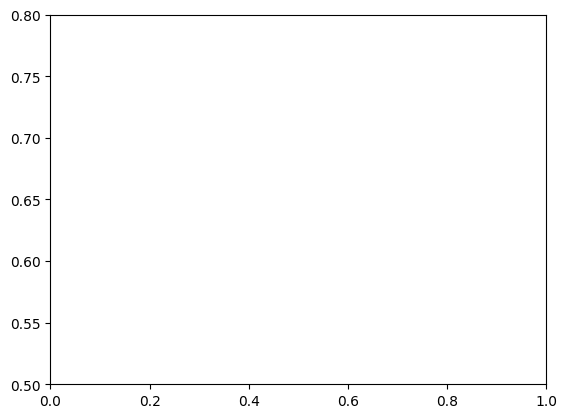

In [ ]:
# TODO: plot training and validation loss
# Your loss is stored at word_val_losses and word_train_losses
import matplotlib.pyplot as plt
x = np.arange(0, 50000, 250)
plt.ylim(0.5, 0.8)

plt.plot(x, word_train_losses, color='orange')
plt.plot(x, word_val_losses)
plt.title('Word Validation Losses & Word Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

In [ ]:
word_train_losses[:5]

[0.0029702677726745606,
 0.6820396900177002,
 0.6919387657642364,
 0.6848987696170807,
 0.6829410603046417]

# Section 2: classification: city names

 Use Names of the Cities dataset. The task is to predict the country a city is in.



### **Dataset Description**

This dataset has a list of city names and their countries as label. The following countries are included in the dataset.

| Index | id | Country |
|----------|----------|----------|
| 0 | af | Afghanistan |
| 1 | cn | China |
| 2 | de | Germany |
| 3 | fi | Finland |
| 4 | fr | France |
| 5 | in | India |
| 6 | ir | Iran |
| 7 | pk | Pakistan |
| 8 | za | South Africa |

Re-define 'group' first by languages

In [ ]:
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]

In [ ]:
city_train_data_raw = readData("/content/", train=True)
city_val_data_raw = readData("/content/", train=False)

X_city, y_city_str = city_train_data_raw
X_val_city, y_val_city_str = city_val_data_raw

seed = 12
local_random = np.random.RandomState(seed)
print(X_city[local_random.choice(len(X_city), 5, replace=False)])
local_random = np.random.RandomState(seed)
print(y_city_str[local_random.choice(len(y_city_str), 5, replace=False)])

['nyarkheyl' 'daxikou' 'galupadeh' 'maohezi' 'airport road']
['af' 'cn' 'de' 'cn' 'ir']


In [ ]:
y_city_str[:5]

array(['af', 'af', 'af', 'af', 'af'], dtype='<U32')

Pre-process `y_city_str` for PyTorch, using the index-id mapping table


In [ ]:
y_city = []
y_val_city = []

for city in y_val_city_str:
  y_val_city.append(languages.index(city))
for city in y_city_str:
  y_city.append(languages.index(city))

y_city = np.array(y_city)
y_val_city = np.array(y_val_city)

In [ ]:
max(y_city)

8

In [ ]:
assert y_city[10] == 0
assert y_city[10000] == 3
assert y_city[25000] == 8
assert y_val_city[10] == 0
assert y_val_city[100] == 1
assert y_val_city[500] == 5

### **multiclass model and functions**

Fixing `RNN()`, `predict()`, `calculateAccuracy()`, and `run()` function to handle multiclass.

Build RNN_multi() for multiclass classification.

In [ ]:
class RNN_multi(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_multi, self).__init__()  # Calling the parent class (nn.Module) initializer

        self.hidden_size = hidden_size  # Define the size of the hidden state

        # Linear layer taking concatenated input and hidden state to the next hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Linear layer to map hidden state to output
        self.h2o = nn.Linear(hidden_size, output_size)
        # LogSoftmax activation for output
        self.softmax = nn.LogSoftmax(dim = 1)


    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
RNN_multi(1,1,1)
RNN_multi(10,10,10)

RNN_multi(
  (i2h): Linear(in_features=20, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Fix `predict()` function to handle multiclass


In [ ]:
def predict_multi(model, X, y=None, loss_func=None):
    with torch.no_grad():
        model.eval()
        pred = []
        val_loss = []
        for ind in range(X.shape[0]):
            hidden = model.initHidden().to(device)
            val = lineToTensor(X[ind])
            for i in range(val.size()[0]):
                output, hidden = model(val[i], hidden)
            log_probabilities = output.cpu().data

            try:
              prediction = list(log_probabilities[0]).index(max(log_probabilities[0]))
            except:
              prediction = random.randint(0, len(log_probabilities[0]))

            pred.append(prediction)

            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_loss.append(loss_func(output, category_tensor).data.item())

    if y is not None and loss_func is not None:
        return sum(val_loss) / len(val_loss)

    return np.array(pred)

Fix `calculateAccuracy()` function to handle multiclass

In [ ]:
def calculateAccuracy_multi(model, X, y):
    preds = predict_multi(model, X)
    return accuracy_score(preds, y)

Fix `Run()` function

In [ ]:
def run_multi(train_data, val_data, hidden_size, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data

    model = RNN_multi(input_size=len(all_letters), hidden_size=hidden_size, output_size = 9)
    model = model.to(device)
    current_loss = 0
    train_losses = []
    val_losses = []

    for epoch in range(0, n_epochs):
        output, loss, line, category = trainOneEpoch(model,
                    criterion = loss_func,
                    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate),
                    X=X,
                    y=y)
        current_loss += loss

        if epoch % print_every == 0:
            log_probabilities = output.cpu().data
            print(log_probabilities)
            try:
              prediction = list(log_probabilities[0]).index(max(log_probabilities[0]))
            except:
              print('in except')
              prediction = random.randint(0, len(log_probabilities[0])-1)
            correct = 'correct' if prediction == category else 'incorrect (True:%s)' % category
            print('Epoch %d (%d%%)  Loss: %.4f, Word: %s, Prediction: %s | %s' % (epoch, epoch / n_epochs * 100, loss, line, prediction, correct))



        if epoch % plot_every == 0:
            train_losses.append(current_loss/plot_every)
            current_loss= 0

            # Validation Loss
            val_losses.append(predict_multi(model, X_val, y_val, loss_func))

    torch.save(model.state_dict(), model_name)
    return train_losses, val_losses

### **Test the new model**

Test model with guessed hyperparameters

In [ ]:
city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 10,
                              n_epochs = 50000,
                              learning_rate = 0.01,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./city_RNN"
                            )

tensor([[-1.8998, -2.3570, -2.5927, -2.2800, -2.4301, -2.2754, -2.0061, -2.1515,
         -1.9879]])
Epoch 0 (0%)  Loss: 2.4301, Word: les chaumes de saint-aignan, Prediction: 0 | incorrect (True:4)
tensor([[-2.0506, -2.5873, -3.0929, -1.9698, -2.9683, -2.0129, -1.9466, -1.8818,
         -2.0310]])
Epoch 5000 (10%)  Loss: 1.8818, Word: shagail, Prediction: 7 | correct
tensor([[-2.3726, -4.7765, -1.9488, -1.4442, -3.2048, -2.8840, -2.3117, -2.0939,
         -1.6035]])
Epoch 10000 (20%)  Loss: 1.4442, Word: rytkynpera, Prediction: 3 | correct
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan]])
in except
Epoch 15000 (30%)  Loss: nan, Word: jhamrah, Prediction: 8 | incorrect (True:7)
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan]])
in except
Epoch 20000 (40%)  Loss: nan, Word: zar sang-e pa'in, Prediction: 0 | incorrect (True:8)
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan]])
in except
Epoch 25000 (50%)  Loss: nan, Word: honkamaki, Prediction: 4 | incorrect (True:3)
tens

In [ ]:
# Load saved model
test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_multi.load_state_dict(torch.load("./city_RNN"))

<All keys matched successfully>

Calculate validation accuracy and draw a training and validation loss plot.

In [ ]:
test_model_multi.eval()
# TODO: Compute Validation accuracy. Tip: `city_val_data` is the validation dataset!
val_acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
val_acc

0.08555555555555555

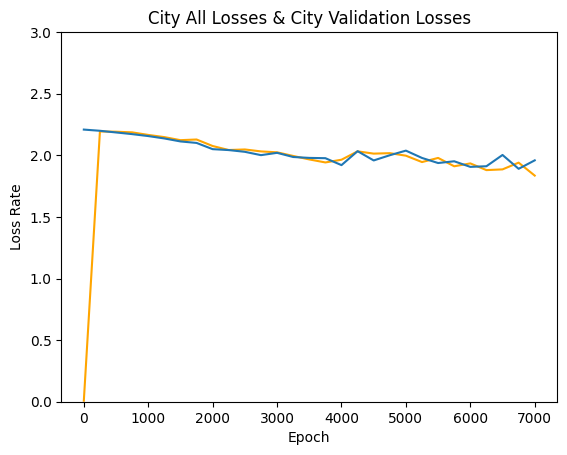

In [ ]:
x = np.arange(0, 50000, 250)
plt.ylim(0, 3)

plt.plot(x, city_all_losses, color='orange')
plt.plot(x, city_val_losses)
plt.title('City All Losses & City Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

### **Hyperparameter tuning**

Tune 3 hyperparameters:   
1. **learning_rate** represents how fast the model learn for each backpropagation.
2. **hidden_size** defines the size of the hidden layer in RNN model. The larger the size, the more complex model be.
3. **n_epochs** controls the number of epoch the model use for training.

####Learning rate tunning

First step adjust the learning_rate = {0.0002, 0.002 0.02}

##***Report for changes in learning rate:***
When learning rate is too large like 0.02, then the model might skipped many important features and causes some divergent behavior of the loss function, therefore the model failed to make any predictions. But for the learning rate of 0.0002, the step of backpropogation is too often and make too many updates in the weight, and this make the model have really slow training process and made many waste in the resources as many of the updates are too close to each other.

When the size of the learning rate is appropriate (in the lr = 0.002 case), the loss of the model is not going to diverge but just having a steady and small fluctuation.

In [ ]:
losses_varies_lr = []
learning_rate = [0.0002, 0.002, 0.02]
for lr in learning_rate:
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 10,
                              n_epochs = 50000,
                              learning_rate = lr,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./city_RNN" + "_" + str(lr)
                            )
  losses_varies_lr.append((lr, city_all_losses, city_val_losses))


tensor([[-2.3141, -2.1871, -2.1962, -2.4560, -2.0446, -2.0966, -2.4531, -2.0667,
         -2.0641]])
Epoch 0 (0%)  Loss: 2.1871, Word: laidicun, Prediction: 4 | incorrect (True:1)
tensor([[-2.2652, -2.1900, -2.1596, -2.4561, -2.0702, -2.1275, -2.4135, -2.1035,
         -2.0691]])
Epoch 5000 (10%)  Loss: 2.1900, Word: longyang zhen, Prediction: 8 | incorrect (True:1)
tensor([[-2.2692, -2.1790, -2.2017, -2.3735, -2.0391, -2.0814, -2.4441, -2.1167,
         -2.1409]])
Epoch 10000 (20%)  Loss: 2.3735, Word: huuhkaala, Prediction: 4 | incorrect (True:3)
tensor([[-2.2356, -2.1636, -2.2043, -2.3414, -2.0997, -2.2299, -2.3452, -2.1208,
         -2.0728]])
Epoch 15000 (30%)  Loss: 2.2299, Word: pitingao, Prediction: 8 | incorrect (True:5)
tensor([[-2.3356, -2.1919, -2.1968, -2.2957, -2.0310, -2.1134, -2.3546, -2.1348,
         -2.1674]])
Epoch 20000 (40%)  Loss: 2.2957, Word: lafitole, Prediction: 4 | incorrect (True:3)
tensor([[-2.2104, -2.1884, -2.2385, -2.3125, -2.1134, -2.1914, -2.3175, -2.

In [ ]:
import pickle
with open('losses_varies_lr', 'wb') as fp:
    pickle.dump(losses_varies_lr, fp)

In [ ]:
with open ('losses_varies_lr', 'rb') as fp:
    losses_varies_lr = pickle.load(fp)

In [ ]:
# Model with learning rate 0.0002
test_model_lr1_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_lr1_multi.load_state_dict(torch.load("./city_RNN_0.0002"))

<All keys matched successfully>

0.16777777777777778


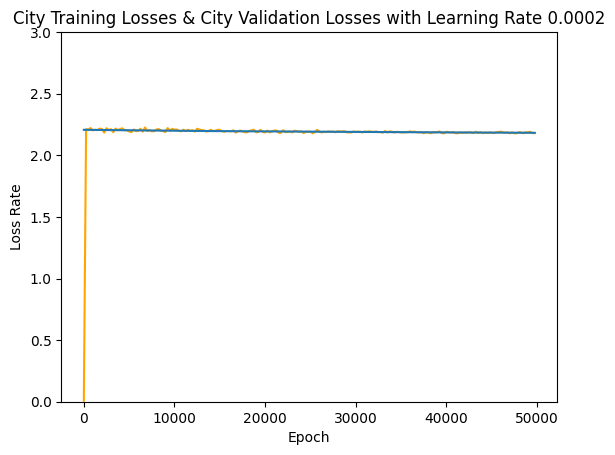

In [ ]:
test_model_lr1_multi.eval()
# Compute Validation accuracy. `city_val_data`  = validation dataset
val_acc_lr1 = calculateAccuracy_multi(test_model_lr1_multi, city_val_data[0], city_val_data[1])
print(val_acc_lr1)
# Draw training and validation loss plot
x = np.arange(0, 50000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_lr[0][1], color='orange')
plt.plot(x, losses_varies_lr[0][2])
plt.title('City Training Losses & City Validation Losses with Learning Rate 0.0002')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

In [ ]:
# Model with learning rate 0.002
test_model_lr2_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_lr2_multi.load_state_dict(torch.load("./city_RNN_0.002"))

<All keys matched successfully>

0.37444444444444447


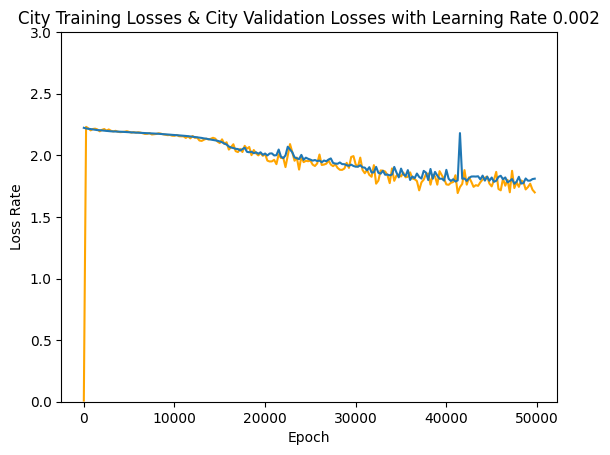

In [ ]:
test_model_lr2_multi.eval()
# Compute Validation accuracy.
val_acc_lr2 = calculateAccuracy_multi(test_model_lr2_multi, city_val_data[0], city_val_data[1])
print(val_acc_lr2)
# Draw training and validation loss plot
x = np.arange(0, 50000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_lr[1][1], color='orange')
plt.plot(x, losses_varies_lr[1][2])
plt.title('City Training Losses & City Validation Losses with Learning Rate 0.002')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

#### hidden layer size tunning

adjust hidden_size = {10, 50, 100}

##***Report for changes in Hidden Layer Size:***
As the size of the hidden layer increasing, the accuracy of the model increased because the model is better fit the data. For the first two value of the hidden layer (hidden size = 10 and 50), we found that around the epoch number in 40000, there are a significant increasing in the loss in both of model and then the two models reduce the loss very slowly. But with the hidden size equals to 100, the increasing in loss around 40000 epoch is just a slight spike. This might resulted that the around epoch of 40000, there is a outlier feature learned by the model, and the model with lower hidden size is underfitting, therefore, the effects of that feature is huge, but with a larger hidden layer size, the model could fit the data better, such that reduce the effect of an outlier feature it learned from the data.

In [ ]:
losses_varies_hz = []
hidden_sizes = [10, 50, 100]
for hz in hidden_sizes:
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = hz,
                              n_epochs = 50000,
                              learning_rate = 0.002,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./city_RNN" + "_hz_" + str(hz)
                            )
  losses_varies_hz.append((hz, city_all_losses, city_val_losses))

tensor([[-2.0382, -2.2470, -2.0690, -2.4526, -2.1684, -2.3634, -2.1247, -2.3725,
         -2.0368]])
Epoch 0 (0%)  Loss: 2.3725, Word: tong, Prediction: 8 | incorrect (True:7)
tensor([[-2.1809, -2.2318, -2.1697, -2.3484, -2.0680, -2.2545, -2.1309, -2.2537,
         -2.1639]])
Epoch 5000 (10%)  Loss: 2.0680, Word: portets, Prediction: 4 | correct
tensor([[-2.1415, -2.3533, -2.1755, -2.1657, -2.1707, -2.2450, -2.1631, -2.1684,
         -2.2083]])
Epoch 10000 (20%)  Loss: 2.2083, Word: pir-i-bazar, Prediction: 0 | incorrect (True:8)
tensor([[-2.1085, -2.3394, -2.0939, -2.2484, -2.1927, -2.2137, -2.1952, -2.1457,
         -2.2615]])
Epoch 15000 (30%)  Loss: 2.2484, Word: fich, Prediction: 2 | incorrect (True:3)
tensor([[-2.0825, -2.8763, -2.2310, -2.2672, -1.5970, -2.4733, -2.2450, -2.3607,
         -2.1127]])
Epoch 20000 (40%)  Loss: 2.0825, Word: qowl bars, Prediction: 4 | incorrect (True:0)
tensor([[-1.5864, -7.3166, -1.5189, -2.7150, -2.0935, -5.1554, -1.9418, -2.0579,
         -2.2135

In [ ]:
# Model with hidden size 10
test_model_hz1_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_hz1_multi.load_state_dict(torch.load("./city_RNN_hz_10"))

<All keys matched successfully>

0.28888888888888886


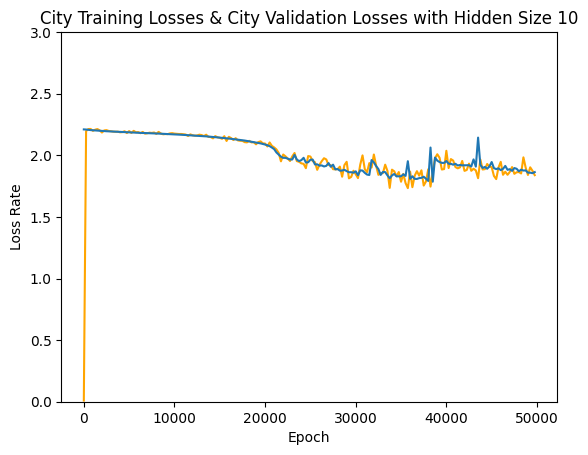

In [ ]:
test_model_hz1_multi.eval()
# Compute Validation accuracy.
val_acc_hz1 = calculateAccuracy_multi(test_model_hz1_multi, city_val_data[0], city_val_data[1])
print(val_acc_hz1)
# Draw training and validation loss plot
x = np.arange(0, 50000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_hz[0][1], color='orange')
plt.plot(x, losses_varies_hz[0][2])
plt.title('City Training Losses & City Validation Losses with Hidden Size 10')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

In [ ]:
# Model with hidden size 50
test_model_hz2_multi = RNN_multi(input_size=len(all_letters), hidden_size=50, output_size=len(languages)).to(device)
test_model_hz2_multi.load_state_dict(torch.load("./city_RNN_hz_50"))

<All keys matched successfully>

0.37333333333333335


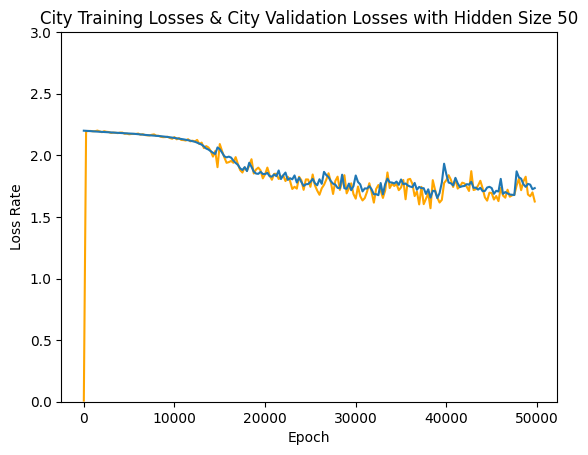

In [ ]:
test_model_hz2_multi.eval()
# Compute Validation accuracy.
val_acc_hz2 = calculateAccuracy_multi(test_model_hz2_multi, city_val_data[0], city_val_data[1])
print(val_acc_hz2)
# Draw training and validation loss plot
x = np.arange(0, 50000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_hz[1][1], color='orange')
plt.plot(x, losses_varies_hz[1][2])
plt.title('City Training Losses & City Validation Losses with Hidden Size 50')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

In [ ]:
# Model with hidden size 100
test_model_hz3_multi = RNN_multi(input_size=len(all_letters), hidden_size=100, output_size=len(languages)).to(device)
test_model_hz3_multi.load_state_dict(torch.load("./city_RNN_hz_100"))

<All keys matched successfully>

0.4211111111111111


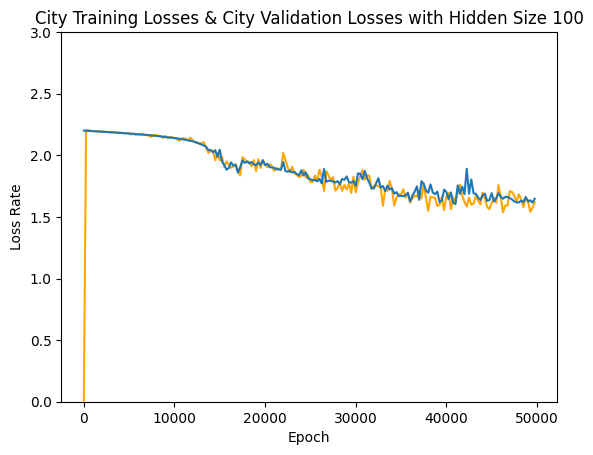

In [ ]:
test_model_hz3_multi.eval()
# Compute Validation accuracy.
val_acc_hz3 = calculateAccuracy_multi(test_model_hz3_multi, city_val_data[0], city_val_data[1])
print(val_acc_hz3)
# Draw training and validation loss plot
x = np.arange(0, 50000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_hz[2][1], color='orange')
plt.plot(x, losses_varies_hz[2][2])
plt.title('City Training Losses & City Validation Losses with Hidden Size 100')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

In [ ]:
with open('losses_varies_hz', 'wb') as fp:
    pickle.dump(losses_varies_hz, fp)

In [ ]:
import pickle
with open ('losses_varies_hz', 'rb') as fp:
    losses_varies_hz = pickle.load(fp)

#### epoch tuning

adjust the model with epoch = {1000, 50000, 100000}

##***Report for changes in Epoch number:***
As the epoch number equals to 1000, the model almost never be updated, therefore, the loss of the model remains unchanges and the model is underfitted because it did not gain enough information from the dataset to make any sensible prediction.

As the number of epoch increasing, the accuracy of the model increases, this is because a larger number in epoch means more updates in the weight of the model, so the model gains more features from the dataset. In this case, 100000 is the best testing value for epoch. But, if the number of epoch keep increasing, the model will be update more time than optimal and the model is going to be overfitted.

In [ ]:
losses_varies_ep = []
epoch = [1000, 50000, 100000]
for ep in epoch:
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 100,
                              n_epochs = ep,
                              learning_rate = 0.002,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./city_RNN" + "_ep_" + str(ep)
                            )
  losses_varies_ep.append((ep, city_all_losses, city_val_losses))

tensor([[-2.2503, -2.1646, -2.1505, -2.1340, -2.1875, -2.2604, -2.1889, -2.2316,
         -2.2150]])
Epoch 0 (0%)  Loss: 2.1646, Word: syadyan, Prediction: 3 | incorrect (True:1)
tensor([[-2.2013, -2.1845, -2.2004, -2.2619, -2.2109, -2.2022, -2.3278, -2.1420,
         -2.0651]])
Epoch 0 (0%)  Loss: 2.0651, Word: allerton, Prediction: 8 | correct
tensor([[-2.1800, -2.2817, -2.2060, -2.1735, -2.1986, -2.2442, -2.2254, -2.0770,
         -2.2016]])
Epoch 5000 (10%)  Loss: 2.2254, Word: deh mirza'i, Prediction: 7 | incorrect (True:6)
tensor([[-1.9256, -2.3718, -2.2662, -2.2645, -2.2181, -2.3639, -2.1105, -2.1511,
         -2.1812]])
Epoch 10000 (20%)  Loss: 2.1511, Word: shutrak, Prediction: 0 | incorrect (True:7)
tensor([[-2.5578, -2.1008, -2.2891, -1.9808, -2.2809, -2.1221, -2.2918, -2.0394,
         -2.2285]])
Epoch 15000 (30%)  Loss: 2.2285, Word: siah gusheh-ye nurza'i, Prediction: 3 | incorrect (True:8)
tensor([[-1.9123, -3.8370, -2.1405, -2.2101, -1.9761, -3.1265, -2.1031, -2.1357,
 

In [ ]:
with open('losses_varies_ep', 'wb') as fp:
    pickle.dump(losses_varies_ep, fp)

In [ ]:
with open ('losses_varies_hz', 'rb') as fp:
    losses_varies_hz = pickle.load(fp)

In [ ]:
# Model with epoch 1000
test_model_ep1_multi = RNN_multi(input_size=len(all_letters), hidden_size=100, output_size=len(languages)).to(device)
test_model_ep1_multi.load_state_dict(torch.load("./city_RNN_ep_1000"))

<All keys matched successfully>

0.10444444444444445


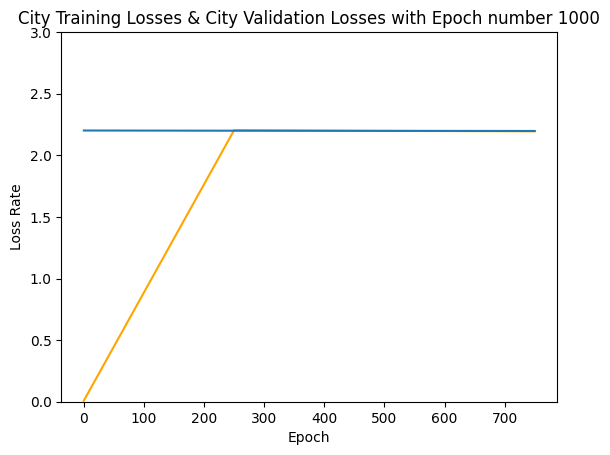

In [ ]:
test_model_ep1_multi.eval()
# Compute Validation accuracy.
val_acc_ep1 = calculateAccuracy_multi(test_model_ep1_multi, city_val_data[0], city_val_data[1])
print(val_acc_ep1)
# Draw training and validation loss plot
x = np.arange(0, 1000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_ep[0][1], color='orange')
plt.plot(x, losses_varies_ep[0][2])
plt.title('City Training Losses & City Validation Losses with Epoch number 1000')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

In [ ]:
# Model with epoch 50000
test_model_ep2_multi = RNN_multi(input_size=len(all_letters), hidden_size=100, output_size=len(languages)).to(device)
test_model_ep2_multi.load_state_dict(torch.load("./city_RNN_ep_50000"))

<All keys matched successfully>

0.4211111111111111


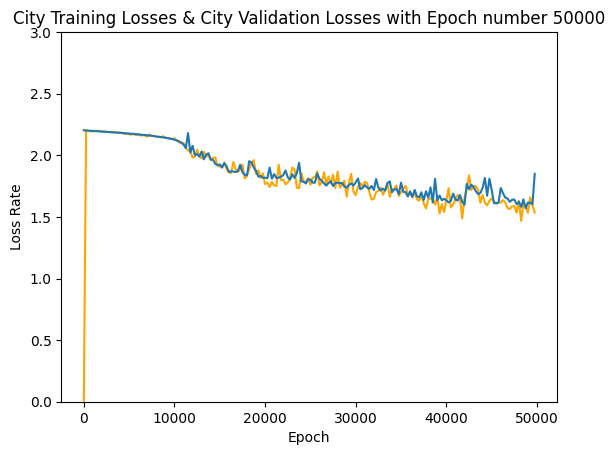

In [ ]:
test_model_ep2_multi.eval()
# Compute Validation accuracy.
val_acc_ep2 = calculateAccuracy_multi(test_model_ep2_multi, city_val_data[0], city_val_data[1])
print(val_acc_ep2)
# Draw training and validation loss plot
x = np.arange(0, 50000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_ep[1][1], color='orange')
plt.plot(x, losses_varies_ep[1][2])
plt.title('City Training Losses & City Validation Losses with Epoch number 50000')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

In [ ]:
# Model with epoch 100000
test_model_ep3_multi = RNN_multi(input_size=len(all_letters), hidden_size=100, output_size=len(languages)).to(device)
test_model_ep3_multi.load_state_dict(torch.load("./city_RNN_ep_100000"))

<All keys matched successfully>

0.47444444444444445


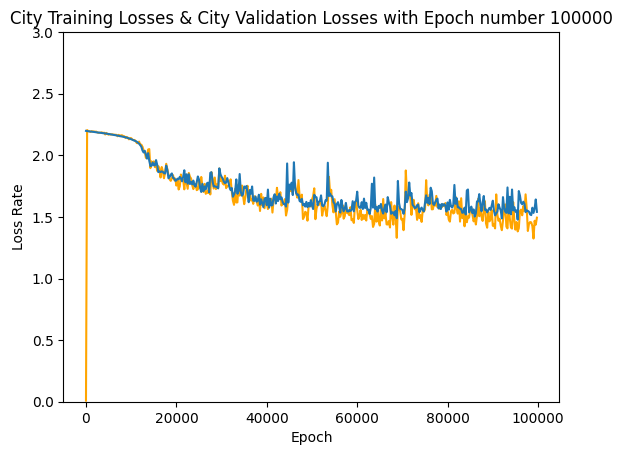

In [ ]:
test_model_ep3_multi.eval()
# Compute Validation accuracy.
val_acc_ep3 = calculateAccuracy_multi(test_model_ep3_multi, city_val_data[0], city_val_data[1])
print(val_acc_ep3)
# Draw training and validation loss plot
x = np.arange(0, 100000, 250)
plt.ylim(0, 3)
plt.plot(x, losses_varies_ep[2][1], color='orange')
plt.plot(x, losses_varies_ep[2][2])
plt.title('City Training Losses & City Validation Losses with Epoch number 100000')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()